In [1]:
!pip install optuna
!pip install xgboost

In [2]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 587, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 587 (delta 122), reused 85 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (587/587), 193.00 KiB | 998.00 KiB/s, done.
Resolving deltas: 100% (296/296), done.
Installing RAPIDS remaining 25.02 libraries
error: a value is required for '--prerelease <PRERELEASE>' but none was supplied
  [possible values: disallow, allow, if-necessary, explicit, if-necessary-or-explicit]

For more information, try '--help'.

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooti

In [3]:
import  numpy as np
import os
import cv2
from tqdm import tqdm
import cupy as cp
import pickle
import optuna
import zipfile
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.feature import hog
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import drive
from cuml.decomposition import PCA
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [8]:
!7z x /content/drive/MyDrive/archive.zip.001 -o/content/datasets


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 2097152000 bytes (2000 MiB)

Extracting archive: /content/drive/MyDrive/archive.zip.001
  0% 1 Open             4% 4096 Open               98% 81920 Open               --
Path = /content/drive/MyDrive/archive.zip.001
Type = Split
Physical Size = 2097152000
Volumes = 3
Total Physical Size = 4316009256
----
Path = archive.zip
Size = 4316009256
--
Path = archive.zip
Type = zip
Physical Size = 4316009256
64-bit = +

  0%      0% 252          0% 490 - MildDemented/MildDemented/OAS1_0035_MR1_1.nii_slice_143.png

In [9]:
data_dir = "datasets"

categories = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

class_count = {}

for class_name in categories:
    class_dir = os.path.join(data_dir, class_name, class_name)
    num_images = len(os.listdir(class_dir))
    class_count[class_name] = num_images
print(class_count)

{'NonDemented': 63560, 'VeryMildDemented': 13800, 'MildDemented': 5184, 'ModerateDemented': 376}


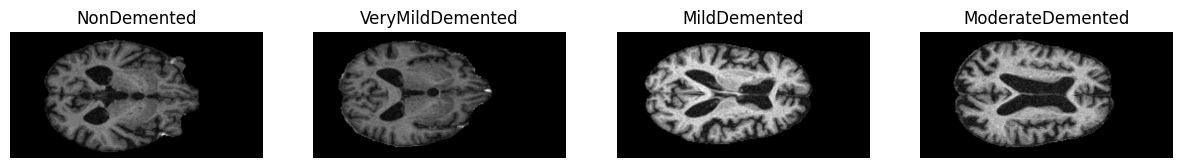

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i, class_name in enumerate(categories):
    class_dir = os.path.join(data_dir, class_name, class_name)
    sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])
    img = cv2.imread(sample_image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis("off")

In [10]:
image_size = 64

x = []
y = []

valid_extensions = (".jpg", ".jpeg", ".png")

for label, category in enumerate(categories):
    path = os.path.join(data_dir, category, category)
    print(f"Reading category: {category}, Label: {label}")

    for image_name in tqdm(os.listdir(path)):
        if not image_name.lower().endswith(valid_extensions):
            continue

        image_path = os.path.join(path, image_name)

        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))

        x.append(img)
        y.append(label)

x = np.array(x)
y = np.array(y)

print("Shape of x:", x.shape)
print("Shape of y:", y.shape)


Reading category: NonDemented, Label: 0


100%|██████████| 63560/63560 [04:15<00:00, 248.41it/s]


Reading category: VeryMildDemented, Label: 1


100%|██████████| 13800/13800 [00:48<00:00, 281.85it/s]


Reading category: MildDemented, Label: 2


100%|██████████| 5184/5184 [00:21<00:00, 242.97it/s]


Reading category: ModerateDemented, Label: 3


100%|██████████| 376/376 [00:01<00:00, 275.58it/s]


Shape of x: (82916, 64, 64)
Shape of y: (82916,)


Text(0, 0.5, 'Count')

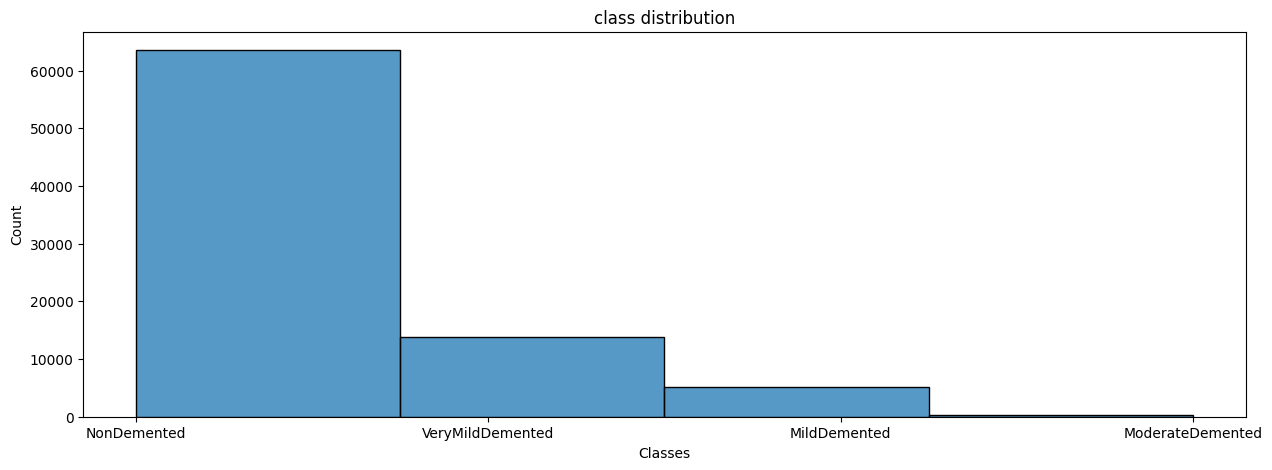

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(y, bins=len(categories))
plt.title("class distribution")
plt.xlabel("Classes")
plt.xticks([0, 1, 2, 3], labels=categories)
plt.ylabel("Count")

In [11]:
x_cupy = x / 255.0
y_cupy = y

In [12]:
def extract_hog_features(image):
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=False,)
    return features

x_hog_features = np.array([extract_hog_features(img) for img in x_cupy])

pca = PCA(n_components=min(100, x_hog_features.shape[0]))
x_pca = pca.fit_transform(x_hog_features)

print( x_hog_features.shape)
print(x_pca.shape)


(82916, 1764)
(82916, 100)


In [13]:
with open('/content/drive/MyDrive/MyModels/pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_cupy, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)

(66332, 100)
(66332,)


In [ ]:
def optimize_svm(trial):
    c = trial.suggest_categorical('C', [0.01, 0.1, 1, 10])

    model = SVC(C=c, random_state=42)
    accuracy = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(optimize_svm, n_trials=10)

best_param_svm = study.best_params

print(best_param_svm)

[I 2025-03-28 21:32:36,361] A new study created in memory with name: no-name-cb2713ae-2bff-4cc1-a15a-3d9a55124065
[I 2025-03-28 21:34:24,901] Trial 0 finished with value: 0.9878037697063469 and parameters: {'C': 10}. Best is trial 0 with value: 0.9878037697063469.
[I 2025-03-28 21:34:50,412] Trial 1 finished with value: 0.7707139775243892 and parameters: {'C': 0.01}. Best is trial 0 with value: 0.9878037697063469.
[I 2025-03-28 21:35:27,055] Trial 2 finished with value: 0.9418531106774519 and parameters: {'C': 1}. Best is trial 0 with value: 0.9878037697063469.
[I 2025-03-28 21:37:15,991] Trial 3 finished with value: 0.9878037697063469 and parameters: {'C': 10}. Best is trial 0 with value: 0.9878037697063469.
[I 2025-03-28 21:39:06,465] Trial 4 finished with value: 0.9878037697063469 and parameters: {'C': 10}. Best is trial 0 with value: 0.9878037697063469.
[I 2025-03-28 21:39:43,217] Trial 5 finished with value: 0.7886540559636976 and parameters: {'C': 0.1}. Best is trial 0 with value

{'C': 10}


In [ ]:
best_svm = SVC(**best_param_svm, probability=True)
best_svm.fit(x_train, y_train)

y_pred = best_svm.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9899903521466473


In [ ]:
def optimize_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 50, 150, step=10)
  max_dept = trial.suggest_int('max_depth', 5, 10, 15)
  min_samples_split = trial.suggest_int('min_samples_split', 3, 5, 7)

  model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_dept, min_samples_split=min_samples_split, random_state=42)

  accuracy = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy').mean()
  return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(optimize_rf, n_trials=10)

best_param_rf = study.best_params

print(best_param_rf)

[I 2025-03-28 21:45:04,778] A new study created in memory with name: no-name-0061a879-cef3-4eb8-a5a2-2786950bbca3
<ipython-input-15-ccfbd1f266a2>:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_dept = trial.suggest_int('max_depth', 5, 10, 15)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
<ipython-input-15-ccfbd1f266a2>:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_split = trial.suggest_int('min_samples_split', 3, 5, 7)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [3, 5] and step=7, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.w

{'n_estimators': 90, 'max_depth': 5, 'min_samples_split': 3}


In [ ]:
best_rf = RandomForestClassifier(**best_param_rf)
best_rf.fit(x_train, y_train)

y_pred = best_rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7656777616980222


In [ ]:
def optimize_xgb(trial):
  n_estimators = trial.suggest_int('n_estimators', 20, 70, step=10)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
  max_depth = trial.suggest_int('max_depth', 5, 10, 15)

  model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

  accuracy = cross_val_score(model, x_train, y_train, cv=3, scoring='accuracy').mean()
  return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(optimize_xgb, n_trials=10)

best_param_xgb = study.best_params

print(best_param_xgb)

[I 2025-03-28 21:46:51,634] A new study created in memory with name: no-name-632d5fbd-3c17-46e1-b969-13ff36efd6d4
<ipython-input-17-01b72ea1d264>:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 5, 10, 15)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [5, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
[I 2025-03-28 21:47:32,288] Trial 0 finished with value: 0.7891364835956471 and parameters: {'n_estimators': 60, 'learning_rate': 0.059150248800743245, 'max_depth': 5}. Best is trial 0 with value: 0.7891364835956471.
<ipython-input-17-01b72ea1d264>:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 5, 10, 15)
/usr/local/lib/

{'n_estimators': 70, 'learning_rate': 0.09898975881152927, 'max_depth': 5}


In [ ]:
best_xgb = XGBClassifier(n_estimators = 70, tree_method = "hist", device = "cuda")
best_xgb.fit(x_train, y_train)

y_pred = best_xgb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.8089122045344911


In [ ]:
base_models = [
    ('svm', best_svm),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

stacking_model.fit(x_train, y_train)
y_pred_stack = stacking_model.predict(x_test)

print(classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12646
           1       0.99      0.97      0.98      2840
           2       0.99      0.97      0.98      1014
           3       0.98      0.98      0.98        84

    accuracy                           0.99     16584
   macro avg       0.99      0.98      0.98     16584
weighted avg       0.99      0.99      0.99     16584



In [ ]:
with open("stacking_model.pkl", "wb") as f:
  pickle.dump(stacking_model, f)


Test the model without running all the code 

In [ ]:
drive.mount('/content/drive')

In [14]:
with open('/content/drive/MyDrive/MyModels/pca.pkl', 'rb') as f:
  pca = pickle.load(f)

with open("/content/drive/MyDrive/MyModels/stacking_model.pkl", "rb") as f:
  stacking = pickle.load(f)


In [26]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((64, 64))

    img_np = np.array(img)

    hog_features = hog(img_np, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)

    hog_features = np.array(hog_features, dtype=np.float32).reshape(1, -1)

    pca_features = pca.transform(hog_features)

    return pca_features


img_path = "/content/drive/MyDrive/pictures/test.png"

img = preprocess_image(img_path)
prediction = stacking.predict(img)

print("prediction image:",prediction)

prediction image: [1]
